# Self-Driving Car Nanodegree

## Project: Finding Lane Lines on the Road

In [1]:
# Import packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
import os
test_imgs = os.listdir("test_images/")

## Lane Lines on Images

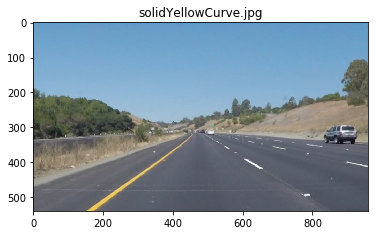

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


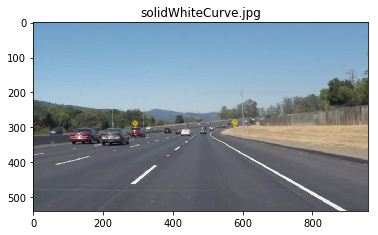

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


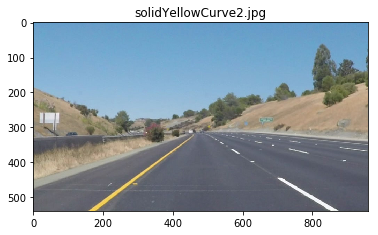

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


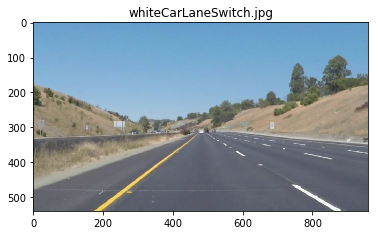

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


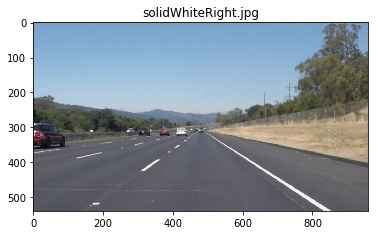

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


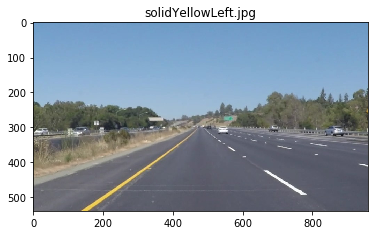

The image is the type <class 'numpy.ndarray'> and the image shape (540, 960, 3)


In [3]:
read_imgset = []

for img in test_imgs:
    image = mpimg.imread("test_images/{}".format(img))
    read_imgset.append(image)
    plt.figure()
    plt.title(img)
    plt.imshow(image)
    plt.show()
    print("The image is the type {} and the image shape {}".format(type(image), image.shape))

### Grayscale Image

In [4]:
def grayscale(img):
    """
    Applies the GrayScale transform.
    This will return an image with only one color channel
    NOTE: To view the image in grayscale you should call the following
    plt.imshow(image, cmap="gray")
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [5]:
gray_imgset = []

for img in read_imgset:
    gray = grayscale(img)
    gray_imgset.append(gray)
    # plt.figure()
    # plt.imshow(gray, cmap="gray")

### Gaussian Blur

In [6]:
def gaussian_blur(img, kernel_size):
    """ Applies a Gaussian Noise kernal"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [7]:
gaussian_imgset = []

for img in gray_imgset:
    gaussian = gaussian_blur(img = img, kernel_size=5)
    gaussian_imgset.append(gaussian)
   # plt.figure()
   # plt.imshow(gaussian, cmap="gray")

### Canny Edges

In [8]:
def canny(img, low_threshold, high_threshold):
    """ Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [9]:
canny_imgset = []

for img in gaussian_imgset:
    canny_img = canny(img, 50, 150)
    canny_imgset.append(canny_img)
   # plt.figure()
   # plt.imshow(canny_img, cmap="gray")

### Region of Interest

In [10]:
def region_of_interest(img, vertices):
    '''
    Applies an image mask.
    
    Only keep the region of the image defined by the polygon
    formed from 'vertices'. The rest of the image is set to black
    '''
    
    # defining a blank mask to start with
    mask = np.zeros_like(img)
    
    # Defining a 3 channel or 1 channel color to fill the mask with
    # depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color=255
        
    
    # Filling the Pixels inside the polygon defined by 'vertices' with
    # the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [11]:
region_imgset = []

for img in canny_imgset:
    
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)

    masked_image = region_of_interest(img, vertices)

    region_imgset.append(masked_image)
  #  plt.figure()
  #  plt.imshow(masked_image)

### Draw Lines

In [12]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=7):    
    """ 
    Function to draw a line
    Takes an array of hough lines and separates them by positive/
    negatives slopes.
    The y-axis is inverted in matplotlib, so the calculated positve 
    slopes will be right lanes and negative slopes will be left lanes
    Equation being used: y = mx + c; m = gradient, c = intercept
    """
    
    both_y1 = int(img.shape[0]*0.62) # From vertices
    both_y2 = img.shape[0] # 540
    
    # Empty array to break the lines into right lane, left lane
    r_x1s, r_x2s, r_y1s, r_y2s = [], [], [], []
    l_x1s, l_x2s, l_y1s, l_y2s = [], [], [], []

    for line in lines:
        for x1,y1,x2,y2 in line:
           
            # Get the gradient to see if the co-ordinates will be left or right lane
            m = get_m(x1,y1,x2,y2)
            
            if m < 0:
                # Invalid lines
                if m > -0.5 or m < -0.8:
                       continue        
                l_x1s.append(x1)
                l_y1s.append(y1)
                l_x2s.append(x2)
                l_y2s.append(y2)
            else:
                # Invalid lines
                if m < 0.5 or m > 0.8:
                    continue        
                r_x1s.append(x1)
                r_y1s.append(y1)
                r_x2s.append(x2)
                r_y2s.append(y2)
        
    # Get a try case running to exclude any other errors
    # Calculate mean values for the range of values for x1, y1, x2, y2
    # Get the gradient for the mean value for the one single line
    # Get the intercept for the one single line to later calculate x co-ordinates
    # Dont need to calculate y co-ordinate as their limit have been set to 320, 540.
    try:
        mean_r_x1, mean_r_y1 = int(np.mean(r_x1s)), int(np.mean(r_y1s))
        mean_r_x2, mean_r_y2 = int(np.mean(r_x2s)), int(np.mean(r_y2s))
        r_m = get_m(mean_r_x1, mean_r_y1, mean_r_x2, mean_r_y2)
        r_c = get_c(mean_r_x1, mean_r_y1, r_m)
        
        right_x1 = get_x(both_y1, r_m, r_c)
        right_x2 = get_x(both_y2, r_m, r_c)
        
        cv2.line(img, (right_x1, both_y1), (right_x2, both_y2), color, thickness)
    except ValueError:
        # Skip error when a line cannot be drawn
        pass

    try:
        mean_l_x1, mean_l_y1 = int(np.mean(l_x1s)), int(np.mean(l_y1s))
        mean_l_x2, mean_l_y2 = int(np.mean(l_x2s)), int(np.mean(l_y2s))
        l_m = get_m(mean_l_x1, mean_l_y1, mean_l_x2, mean_l_y2)
        l_c = get_c(mean_l_x1, mean_l_y1, l_m)

        left_x1 = get_x(both_y1, l_m, l_c)
        left_x2 = get_x(both_y2, l_m, l_c)
        cv2.line(img, (left_x1, both_y1), (left_x2, both_y2), color, thickness)        
    except ValueError:
        # Skip error when a line cannot be drawn
        pass
    
def get_m(x1,y1,x2,y2):
    """Calculates the gradient/slope for a line"""
    return ((y2-y1)/(x2-x1))

def get_c(x, y, m):
    """Calculates the intercept for a line"""
    return y - (m * x)

def get_x(y, m, c):
    """Calculate the x-coordinate for a line"""
    return int((y - c)/m)

### Hough Transform

In [13]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """ Returns an image with hough lines drawn"""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [14]:
hough_imgset = []

for img in region_imgset:
    hough_img = hough_lines(img, rho=1, theta=np.pi/180, threshold=15, min_line_len=40, max_line_gap=20)
    hough_imgset.append(hough_img)
    # plt.figure()
    # plt.imshow(hough_img)

In [15]:
def weighted_img(img, initial_img, alpha=0.8, beta=1, gamma=0):
    """An image with lines drawn"""
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

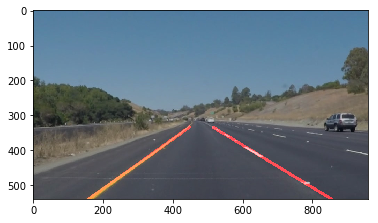

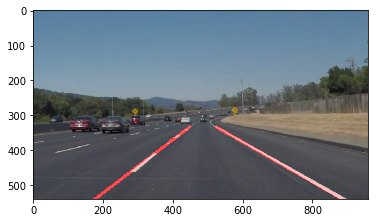

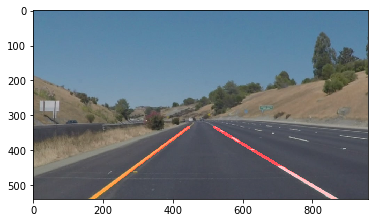

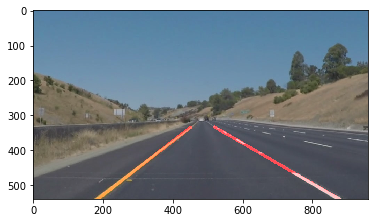

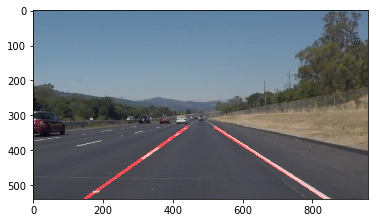

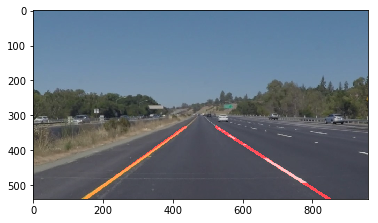

In [16]:
final_imgset = []

for i in range(0,6):
    final_img = weighted_img(hough_imgset[i], read_imgset[i])
    final_imgset.append(final_img)
    plt.figure()
    plt.imshow(final_img)

### Save the Images

The images from test_images are saved in the folder test_images_output with the lane lines annotated on top and in the format .png

In [17]:
# test_imgs = os.listdir("test_images/")

for i in range(0,6):
    fname = test_imgs[i].split('.')[0] + '_lanelines.png'
    plt.imsave(os.path.join('test_images_output', fname), final_imgset[i])

## Pipeline Overview

1. Grayscale
2. Gaussian Blur
3. Canny Edges
4. Region Of Interest
5. Hough Transform

## Lane Lines on a Video

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def process_image(image):
    
    gray = grayscale(image)
    
    gaussian = gaussian_blur(gray, 7)
    
    canny_img = canny(gaussian, 50, 150)
    
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    region = region_of_interest(canny_img, vertices)
    
    hough_img = hough_lines(region, rho=1, theta=np.pi/180, threshold=15, min_line_len=40, max_line_gap=20)
    
    result = weighted_img(hough_img, image)
    
    return result

In [20]:
white_output = "test_videos_output/solidWhiteRight.mp4"
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:15<00:00, 14.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1min 35s, sys: 3.45 s, total: 1min 38s
Wall time: 16.4 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [22]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:52<00:00, 13.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 4min 59s, sys: 11 s, total: 5min 10s
Wall time: 52.9 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Challenge Video

In [24]:
def hsv(img):
    """
    Applies the RGB2HSV transform
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [25]:
def challenge_region(img, vertices):
    '''
    Applies an image mask.
    
    Only keep the region of the image defined by the polygon
    formed from 'vertices'. The rest of the image is set to black
    '''

    # defining a blank mask to start with
    mask = np.zeros_like(img)
    
    # Defining a 3 channel or 1 channel color to fill the mask with
    # depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
        ignore_yellow_color = ()
    else:
        ignore_mask_color=255
        
    
    # Filling the Pixels inside the polygon defined by 'vertices' with
    # the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    

In [26]:
def process_challenge_image(image):
    
    hsv_img = hsv(image)

    gaussian = gaussian_blur(hsv_img, 7)
    
    canny_img = canny(gaussian, 50, 150)
    
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(620, int(imshape[0]*0.62)), (660, int(imshape[0]*0.62)), (imshape[1],imshape[0])]], dtype=np.int32)
    region = challenge_region(canny_img, vertices)
    
    hough_img = hough_lines(region, rho=1, theta=np.pi/180, threshold=50, min_line_len=40, max_line_gap=40)
    
    result = weighted_img(hough_img, image)
    
    return result

In [27]:
challenge_output = 'test_videos_output/challenge.mp4'
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_challenge_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:35<00:00,  6.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 3min 22s, sys: 8.14 s, total: 3min 30s
Wall time: 36.7 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))